## Лабораторная работа №2 Обучение MNIST
### Выполнил Гладкий Андрей Антонович БВТ2202
Цель: написать архитектуру MLP и обучить нейросеть на датасете MNIST

Задачи: 
1) написать свой датасет(класс) и даталаудер 
2) написать архитектуру MLP+классификатор 
3) использовать либо SGD либо Adam в качестве оптимизатора 
4) использовать CrossEntropyLoss в качестве лоссфункции 
5) использовать ReLU в качестве функции активации 
6) переводить модель на cuda, переводить номер класса в one hot вектор, использовать argmax для обратного преобразования

In [2]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.io import read_image
from torchvision import datasets, transforms
import numpy as np
import torch
import math
import matplotlib.pyplot as plt


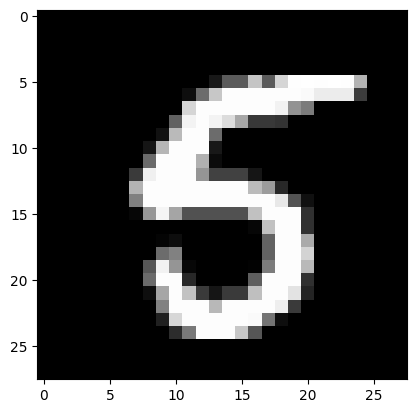

Label: 5


In [18]:
class MNISTDataset(Dataset): # init len getitem обязательные методы
    def __init__(self, train=True):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        self.dataset = datasets.MNIST(root='./data', train=train, download=True, transform=self.transform)

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label 
    
train_dataset = MNISTDataset()
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# проверка, что всё работает
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].squeeze() # squeeze - удаляет все размерности вектора, которые равны 1. Это нужно для уменьшения размерности тензора
label = train_labels[0] # (1, 28, 28).squeeze()->(28, 28)
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [4]:
class MLP(nn.Module):
    def __init__(self, hidden_size=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)          
        self.fc2 = nn.Linear(hidden_size, 10) 
              

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # -1 вычисляет текущую размерность. Изменяет размерность тензора, не изменяя данные
        m = nn.ReLU()
        x = m(self.fc1(x))   
        x = self.fc2(x)
        s = nn.Softmax(dim=1)
        x = s(x)        
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) # learning rate - скорость обучения. (На каждом шаге веса будут изменяться на 0.0003)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = range(10)

In [6]:
device

device(type='cuda')

In [7]:
def train_model(num_epochs=5):
    dataset = train_dataset
    dataloader = train_dataloader

    model.train()
    for epoch in range(num_epochs):
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Обнуление градиентов
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Запуск обучения
train_model(num_epochs=5)

Epoch [1/5], Loss: 1.5242
Epoch [2/5], Loss: 1.6481
Epoch [3/5], Loss: 1.4697
Epoch [4/5], Loss: 1.5857
Epoch [5/5], Loss: 1.5995


In [13]:
def predict(model, image):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.view(-1, 28 * 28))
        np_arr =  output.data.detach().cpu().numpy()
        # print(output.data)
        np.set_printoptions(suppress=True) # вывести массив np без e-01
        p = np.max(np_arr)
        print(np_arr)

        # _, predicted = torch.max(output.data, 1)
        predicted = np.argmax(np_arr)
    return predicted, p

In [20]:
count = 0
for images, labels in test_dataloader:
    if count < 3:
        predicted_class, p = predict(model, images)
        print(f'Predicted: {predicted_class.item()}, Actual: {labels.item()}, Probability: {round(p, 3)}')
    else:
        break  # Предсказываем только для одного изображения
    count += 1
    print("\n")

[[0.00060752 0.00000007 0.01203899 0.02361821 0.00000001 0.00006257
  0.         0.96297854 0.00013207 0.00056194]]
Predicted: 7, Actual: 7, Probability: 0.9629999995231628


[[0.00079299 0.00004563 0.9348008  0.05464897 0.         0.0016369
  0.00114983 0.         0.00692492 0.        ]]
Predicted: 2, Actual: 2, Probability: 0.9350000023841858


[[0.00001105 0.95599276 0.00914019 0.00977586 0.00039518 0.00015254
  0.00464475 0.01416896 0.0053698  0.00034886]]
Predicted: 1, Actual: 1, Probability: 0.9559999704360962


